In [25]:
import numpy as np
import torch

In [43]:
def to_sphere(u, v):    #把2維座標轉換成3維笛卡爾座標
    # result = u + 0.5
    # if result >= 1:
    #     result -= 1
    theta = 2 * np.pi * u
    phi = np.arccos(1 - 2 * v)
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    s = np.stack([cx, cy, cz])

    # 打印調試信息
    print(f"u = {u}, theta = {theta * 180 / np.pi} 度")
    print(f"v = {v}, phi = {phi * 180 / np.pi} 度")
    print(f"球面坐標點: [{cx:.4f}, {cy:.4f}, {cz:.4f}]")
    
    # 計算該點在 xy 平面的角度
    angle = np.arctan2(cy, cx) * 180 / np.pi
    print(f"to_sphere 產生的點的角度: {angle:.2f} 度")
    return s

to_sphere(0.5,0.25)


u = 0.5, theta = 180.0 度
v = 0.25, phi = 60.00000000000001 度
球面坐標點: [-0.8660, 0.0000, 0.5000]
to_sphere 產生的點的角度: 180.00 度


array([-8.66025404e-01,  1.06057524e-16,  5.00000000e-01])

In [27]:
def look_at(eye, at=np.array([0, 0, 0]), up=np.array([0, 0, 1]), eps=1e-5):   #計算從視點(相機位置)到目標點的視角轉換 相機到世界
    at = at.astype(float).reshape(1, 3)
    up = up.astype(float).reshape(1, 3)

    eye = eye.reshape(-1, 3)
    up = up.repeat(eye.shape[0] // up.shape[0], axis=0)
    eps = np.array([eps]).reshape(1, 1).repeat(up.shape[0], axis=0)  #形狀為 (up.shape[0], 1)

    z_axis = eye - at
    z_axis /= np.max(np.stack([np.linalg.norm(z_axis, axis=1, keepdims=True), eps]))  #歸一化

    x_axis = np.cross(up, z_axis)
    x_axis /= np.max(np.stack([np.linalg.norm(x_axis, axis=1, keepdims=True), eps]))

    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.max(np.stack([np.linalg.norm(y_axis, axis=1, keepdims=True), eps]))

    r_mat = np.concatenate((x_axis.reshape(-1, 3, 1), y_axis.reshape(-1, 3, 1), z_axis.reshape(-1, 3, 1)), axis=2)

    return r_mat  #形狀(1,3,3)

In [28]:
def sample_select_pose(u, v):   #計算旋轉矩陣(相機姿勢)
    # sample location on unit sphere
    #print("Type of self.v:", type(self.v))
    loc = to_sphere(u, v)
    # print("cx cy cz:",loc)
    # theta = 2 * np.pi * u
    # phi = np.arccos(1 - 2 * v)

    # print(f"u: {u}, theta: {theta/np.pi*180.}度")
    # print(f"v: {v}, phi: {phi/np.pi*180.}度")
    # print(f"camera position: {loc}")
    
    # sample radius if necessary
    radius = 3.0
    if isinstance(radius, tuple):
        radius = np.random.uniform(*radius)

    loc = loc * radius
    R = look_at(loc)[0]

    RT = np.concatenate([R, loc.reshape(3, 1)], axis=1)
    RT = torch.Tensor(RT.astype(np.float32))

    expected_angle = u * 360
    verify_camera_transform(RT, expected_angle)
    return RT

def verify_camera_transform(c2w, expected_angle):
    # 將張量移到 CPU 並轉換為 NumPy
    if torch.is_tensor(c2w):
        camera_forward = c2w[:3, 2].detach().cpu().numpy()
    else:
        camera_forward = c2w[:3, 2]
    
    # 計算實際角度
    actual_angle = np.degrees(np.arctan2(camera_forward[1], camera_forward[0]))
    if actual_angle < 0:
        actual_angle += 360
        
    print(f"預期角度: {expected_angle}°")
    print(f"實際角度: {actual_angle:.2f}°")
    print(f"相機變換矩陣:\n{c2w.detach().cpu().numpy() if torch.is_tensor(c2w) else c2w}")

In [48]:
for u in [0, 0.25, 0.5, 0.75]:
    pose = sample_select_pose(u, 0.5)
    print(f"u={u}:")
    print("相機位置:", pose[:3, 3])
    print("相機朝向:", pose[:3, 2])
    print("相機右方向:", pose[:3, 0])
    print("相機上方向:", pose[:3, 1])
    print("---")

預期角度: 0°
實際角度: 0.00°
相機變換矩陣:
[[ 0.0000000e+00 -6.1232343e-17  1.0000000e+00  3.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  6.1232343e-17  1.8369701e-16]]
u=0:
相機位置: tensor([3.0000e+00, 0.0000e+00, 1.8370e-16])
相機朝向: tensor([1.0000e+00, 0.0000e+00, 6.1232e-17])
相機右方向: tensor([0., 1., 0.])
相機上方向: tensor([-6.1232e-17,  0.0000e+00,  1.0000e+00])
---
預期角度: 90.0°
實際角度: 90.00°
相機變換矩陣:
[[-1.0000000e+00 -3.7493994e-33  6.1232343e-17  1.8369701e-16]
 [ 6.1232343e-17 -6.1232343e-17  1.0000000e+00  3.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  6.1232343e-17  1.8369701e-16]]
u=0.25:
相機位置: tensor([1.8370e-16, 3.0000e+00, 1.8370e-16])
相機朝向: tensor([6.1232e-17, 1.0000e+00, 6.1232e-17])
相機右方向: tensor([-1.0000e+00,  6.1232e-17,  0.0000e+00])
相機上方向: tensor([-3.7494e-33, -6.1232e-17,  1.0000e+00])
---
預期角度: 180.0°
實際角度: 180.00°
相機變換矩陣:
[[-1.2246469e-16  6.1232343e-17 -1.0000000e+00 -3.0000000e+00]
 [-1.0000000e+00 -7.4987988e-33  1.2246469

In [44]:
print("===========================")
sample_select_pose(0.25,0.5)

u = 0.25, theta = 90.0 度
v = 0.5, phi = 90.0 度
球面坐標點: [0.0000, 1.0000, 0.0000]
to_sphere 產生的點的角度: 90.00 度
預期角度: 90.0°
實際角度: 90.00°
相機變換矩陣:
[[-1.0000000e+00 -3.7493994e-33  6.1232343e-17  1.8369701e-16]
 [ 6.1232343e-17 -6.1232343e-17  1.0000000e+00  3.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  6.1232343e-17  1.8369701e-16]]


tensor([[-1.0000e+00, -3.7494e-33,  6.1232e-17,  1.8370e-16],
        [ 6.1232e-17, -6.1232e-17,  1.0000e+00,  3.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  6.1232e-17,  1.8370e-16]])

In [47]:
def to_sphere(u, v):    #把2維座標轉換成3維笛卡爾座標
    theta = 2 * np.pi *  u
    phi = np.arccos(1 - 2 * v)
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    s = np.stack([cx, cy, cz])
    return s
    
u_test = [0, 0.25, 0.5, 0.75]
v_test = 0.5  # 保持在赤道面上

for u in u_test:
    loc = to_sphere(u, v_test)
    angle = np.arctan2(loc[1], loc[0]) * 180 / np.pi
    print(f"u={u}: 產生角度={angle}度")

u=0: 產生角度=0.0度
u=0.25: 產生角度=90.0度
u=0.5: 產生角度=180.0度
u=0.75: 產生角度=-90.00000000000001度


In [39]:
from graf.transforms import FullRaySampler
H=W=128
fov=25
focal = W/2 * 1 / np.tan((.5 * fov * np.pi/180.))
def sample_select_rays(u ,v):
        pose = sample_select_pose(u, v)
        N_samples = 1024  # 例如 32x32=1024
        ray_sampler = FullRaySampler(#N_samples=N_samples,
                                #      min_scale=0.,
                                #      max_scale=1.0,
                                #      scale_anneal=0.0001,
                                #      random_shift=False, 
                                #      random_scale=False,
                                     orthographic=False)
    
    # 調用採樣器
        batch_rays, select_inds, hw = ray_sampler(H, W, focal, pose)
        return batch_rays, select_inds, hw

sample_select_rays(0, 0.5)

u = 0, theta = 0.0 度
v = 0.5, phi = 90.0 度
球面坐標點: [1.0000, 0.0000, 0.0000]
to_sphere 產生的點的角度: 0.00 度
預期角度: 0°
實際角度: 0.00°
相機變換矩陣:
[[ 0.0000000e+00 -6.1232343e-17  1.0000000e+00  3.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  6.1232343e-17  1.8369701e-16]]


(tensor([[[ 3.0000e+00,  0.0000e+00,  1.8370e-16],
          [ 3.0000e+00,  0.0000e+00,  1.8370e-16],
          [ 3.0000e+00,  0.0000e+00,  1.8370e-16],
          ...,
          [ 3.0000e+00,  0.0000e+00,  1.8370e-16],
          [ 3.0000e+00,  0.0000e+00,  1.8370e-16],
          [ 3.0000e+00,  0.0000e+00,  1.8370e-16]],
 
         [[-1.0000e+00, -2.2169e-01,  2.2169e-01],
          [-1.0000e+00, -2.1823e-01,  2.2169e-01],
          [-1.0000e+00, -2.1477e-01,  2.2169e-01],
          ...,
          [-1.0000e+00,  2.1130e-01, -2.1823e-01],
          [-1.0000e+00,  2.1477e-01, -2.1823e-01],
          [-1.0000e+00,  2.1823e-01, -2.1823e-01]]]),
 tensor([    0,     1,     2,  ..., 16381, 16382, 16383]),
 tensor([[-0.5000, -0.5000],
         [-0.5000, -0.4922],
         [-0.5000, -0.4844],
         ...,
         [ 0.4922,  0.4766],
         [ 0.4922,  0.4844],
         [ 0.4922,  0.4922]]))

In [41]:
u=0.
v=0.5
pose = sample_select_pose(u, v)
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    x = (i-W*.5)/focal
    y = -(j-H*.5)/focal
    z = -torch.ones_like(i)

    dirs = torch.stack([x, y, z], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape) #torch.Size([128, 128, 3])
    
    return rays_o, rays_d

get_rays(H,W, focal, pose)

u = 0.0, theta = 0.0 度
v = 0.5, phi = 90.0 度
球面坐標點: [1.0000, 0.0000, 0.0000]
to_sphere 產生的點的角度: 0.00 度
預期角度: 0.0°
實際角度: 0.00°
相機變換矩陣:
[[ 0.0000000e+00 -6.1232343e-17  1.0000000e+00  3.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  6.1232343e-17  1.8369701e-16]]


(tensor([[[3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          ...,
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16]],
 
         [[3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          ...,
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16]],
 
         [[3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          ...,
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e+00, 0.0000e+00, 1.8370e-16]],
 
         ...,
 
         [[3.0000e+00, 0.0000e+00, 1.8370e-16],
          [3.0000e

In [ ]:
def get_render_poses(radius, angle_range=(0, 360), theta=0, N=40, swap_angles=False):   #用在eval的時候
    poses = []
    theta = max(0.1, theta)
    for angle in np.linspace(angle_range[0],angle_range[1],N+1)[:-1]:
        angle = max(0.1, angle)
        if swap_angles:
            loc = polar_to_cartesian(radius, theta, angle, deg=True)
        else:
            loc = polar_to_cartesian(radius, angle, theta, deg=True)
        R = look_at(loc)[0]
        RT = np.concatenate([R, loc.reshape(3, 1)], axis=1)
        poses.append(RT)
    return torch.from_numpy(np.stack(poses))

def polar_to_cartesian(r, theta, phi, deg=True): #極座標到笛卡爾座標

    if deg:
        phi = phi * np.pi / 180
        theta = theta * np.pi / 180
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    print(f"test球面坐標點: [{cx:.4f}, {cy:.4f}, {cz:.4f}]")
    return r * np.stack([cx, cy, cz])

In [ ]:
c2w = get_render_poses(3, angle_range=(0, 90), theta=90, N=1)

test球面坐標點: [1.0000, 0.0017, 0.0000]


In [ ]:
c2w.shape

torch.Size([1, 3, 4])

In [ ]:
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    x = (i-W*.5)/focal
    y = -(j-H*.5)/focal
    z = -torch.ones_like(i)

    dirs = torch.stack([x, y, z], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape) #torch.Size([128, 128, 3])

    # 在這裡直接驗證射線方向
    rays_d_cpu = rays_d.detach().cpu()
    
    # 檢查中心射線的方向
    def calculate_ray_angle(ray):
        return np.degrees(np.arctan2(ray[0], -ray[2]))
    
    # 檢查射線分布
    center_ray = rays_d_cpu[H//2, W//2]
    left_ray = rays_d_cpu[H//2, 0]
    right_ray = rays_d_cpu[H//2, -1]
    
    # print(f"左邊 x/z: {(-W/2/focal):.4f}")
    # print(f"右邊 x/z: {(W/2/focal):.4f}")
    # print(f"中心射線角度: {calculate_ray_angle(center_ray):.2f}°")
    # print(f"左邊射線角度: {calculate_ray_angle(left_ray):.2f}°")
    # print(f"右邊射線角度: {calculate_ray_angle(right_ray):.2f}°")
    
    return rays_o, rays_d

W = H = 128
fov = 25
focal = W/2 * 1 / np.tan((.5 * fov * np.pi/180.))
ray_0, ray_d = get_rays(W, H, focal, c2w[0])

In [ ]:
ray_d

tensor([[[-0.9996, -0.2234,  0.2217],
         [-0.9996, -0.2200,  0.2217],
         [-0.9996, -0.2165,  0.2217],
         ...,
         [-1.0004,  0.2096,  0.2217],
         [-1.0004,  0.2130,  0.2217],
         [-1.0004,  0.2165,  0.2217]],

        [[-0.9996, -0.2234,  0.2182],
         [-0.9996, -0.2200,  0.2182],
         [-0.9996, -0.2165,  0.2182],
         ...,
         [-1.0004,  0.2096,  0.2182],
         [-1.0004,  0.2130,  0.2182],
         [-1.0004,  0.2165,  0.2182]],

        [[-0.9996, -0.2234,  0.2148],
         [-0.9996, -0.2200,  0.2148],
         [-0.9996, -0.2165,  0.2148],
         ...,
         [-1.0004,  0.2096,  0.2148],
         [-1.0004,  0.2130,  0.2148],
         [-1.0004,  0.2165,  0.2148]],

        ...,

        [[-0.9996, -0.2234, -0.2113],
         [-0.9996, -0.2200, -0.2113],
         [-0.9996, -0.2165, -0.2113],
         ...,
         [-1.0004,  0.2096, -0.2113],
         [-1.0004,  0.2130, -0.2113],
         [-1.0004,  0.2165, -0.2113]],

        [[

In [ ]:
R = look_at(loc)[0]

In [ ]:
RT = sample_select_pose(3, 0.5, 0.5)

In [ ]:
z=[-0.00174533,  0.99999848,  0.        ]
q=[-0.7071057 , -0.00123413,  0.70710678]
np.cross(z,q)

array([0.70710571, 0.00123413, 0.70710678])

In [ ]:
RT

tensor([[-1.2246e-16,  6.1232e-17, -1.0000e+00, -3.0000e+00],
        [-1.0000e+00, -7.4988e-33,  1.2246e-16,  3.6739e-16],
        [ 0.0000e+00,  1.0000e+00,  6.1232e-17,  1.8370e-16]])

In [ ]:
to_sphere(0.5,0.5)

array([-1.0000000e+00,  1.2246468e-16,  6.1232340e-17])

In [ ]:
def polar_to_cartesian(r, theta, phi, deg=True): #極座標到笛卡爾座標

    if deg:
        phi = phi * np.pi / 180
        theta = theta * np.pi / 180
    cx = np.sin(phi) * np.cos(theta)
    cy = np.sin(phi) * np.sin(theta)
    cz = np.cos(phi)
    return r * np.stack([cx, cy, cz])

def get_render_poses(radius, angle_range=(0, 360), theta=0, N=40, swap_angles=False):   #用在eval的時候
    poses = []
    for angle in np.linspace(angle_range[0],angle_range[1],N+1)[:-1]:
        if swap_angles:
            loc = polar_to_cartesian(radius, theta, angle, deg=True)
        else:
            loc = polar_to_cartesian(radius, angle, theta, deg=True)

    return loc

In [ ]:
render_radius = 3.0

def get_render_poses_by_angles(render_radius, azimuth, elevation, N_poses=1):
    """Compute equidistant render poses varying azimuth and polar angle, respectively."""
    # theta = to_theta(u)
    # phi = to_phi(v)
    angle_range = (azimuth, azimuth)

    loc = get_render_poses(render_radius, angle_range=angle_range, theta=elevation, N=N_poses)

    return  loc

angle_positions = [
    (0., 90.),    # 正面 (0度方位角，90度仰角)
    (45., 90.),   # 右前45度
    (90., 90.),   # 右側
    (135., 90.),  # 右後45度
    (180., 90.),  # 背面
    (225., 90.),    # 俯視30度 (90-30=60)
    (270., 90.),   # 仰視30度 (90+30=120)
    (315., 90.),  # 左前45度
]

loc_list = []
for i, (azimuth, elevation) in enumerate(angle_positions):
    loc = get_render_poses_by_angles(render_radius, azimuth, elevation)
    loc_list.append(loc)

In [ ]:
for i, j in zip(angle_positions, loc_list):
    print(i, j)

(0.0, 90.0) [3.0000000e+00 0.0000000e+00 1.8369702e-16]
(45.0, 90.0) [2.12132034e+00 2.12132034e+00 1.83697020e-16]
(90.0, 90.0) [1.8369702e-16 3.0000000e+00 1.8369702e-16]
(135.0, 90.0) [-2.12132034e+00  2.12132034e+00  1.83697020e-16]
(180.0, 90.0) [-3.0000000e+00  3.6739404e-16  1.8369702e-16]
(225.0, 90.0) [-2.12132034e+00 -2.12132034e+00  1.83697020e-16]
(270.0, 90.0) [-5.5109106e-16 -3.0000000e+00  1.8369702e-16]
(315.0, 90.0) [ 2.12132034e+00 -2.12132034e+00  1.83697020e-16]


In [ ]:
c2w = [[ 0.9975641,  -0.02325215,  0.06576703,  0.19730112],
 [ 0.06975647,  0.33252123, -0.9405125,  -2.8215373 ],
 [-0.,          0.9428091,   0.3333332,   0.9999996 ]]

/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36870 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 36870 missing from current font.
  font.set_text(s, 0, flags=flags)


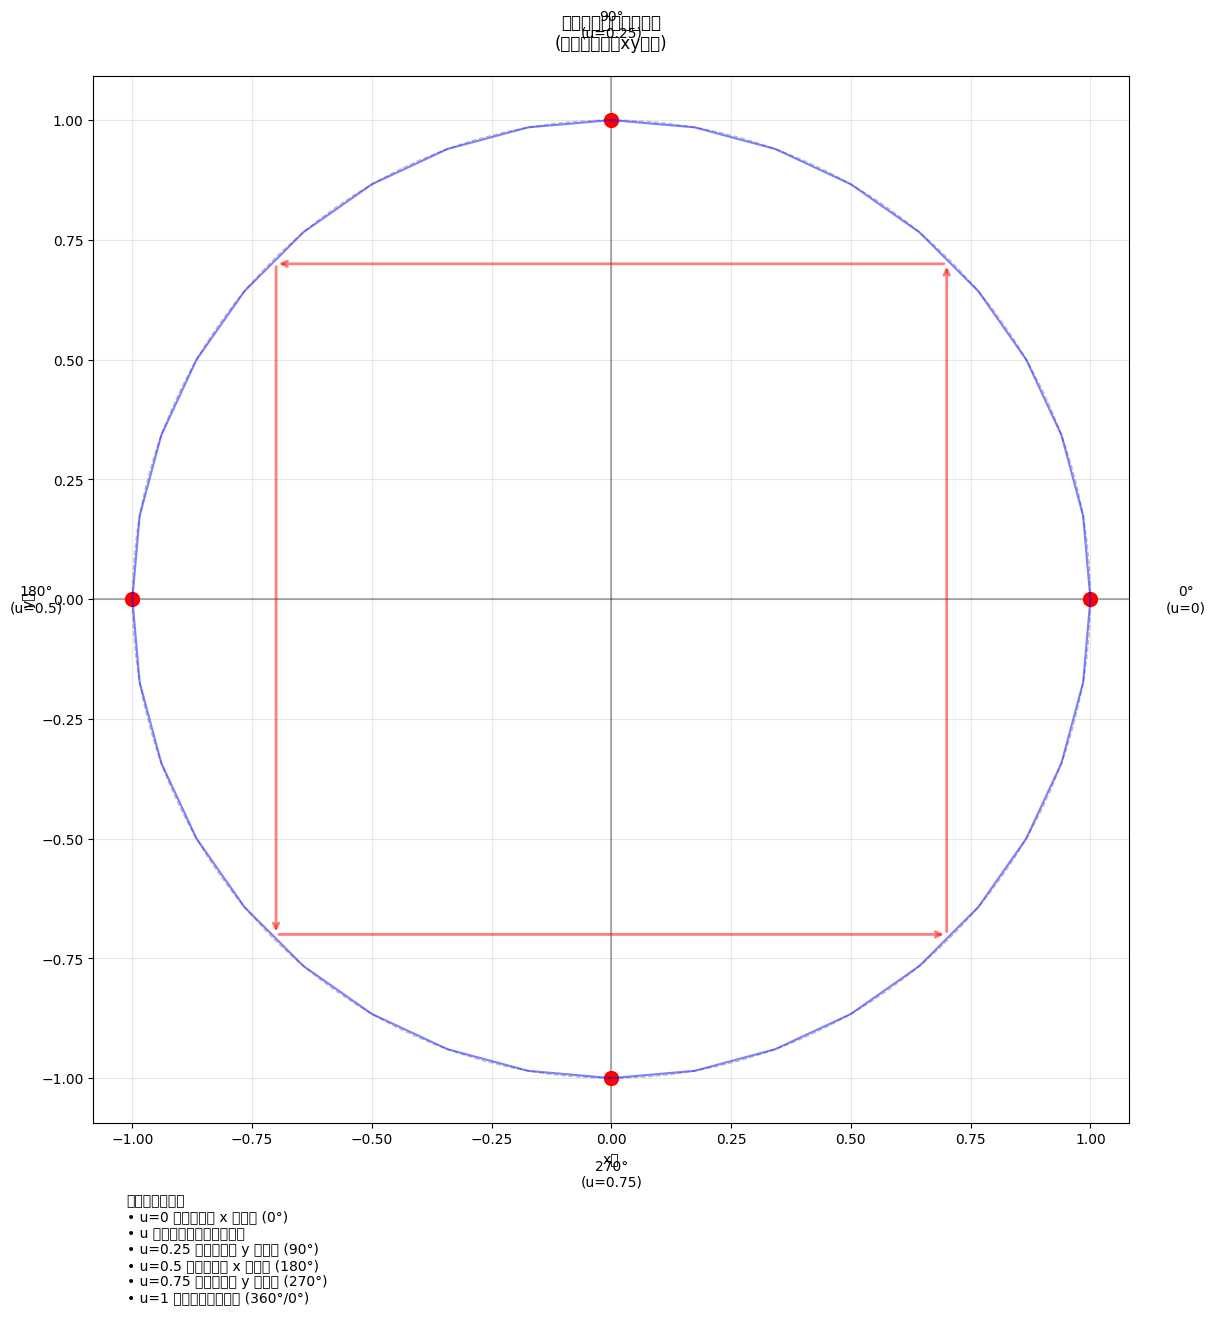

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def to_sphere(u, v):    
    theta = 2 * np.pi * u     
    phi = np.arccos(1 - 2 * v)     
    cx = np.sin(phi) * np.cos(theta)     
    cy = np.sin(phi) * np.sin(theta)     
    cz = np.cos(phi)     
    return np.array([cx, cy, cz])

# 設置更多的u值以展示更平滑的旋轉
v = 0.5
u_values = np.linspace(0, 1, 37)  # 每10度一個點
points = []
angles = []

# 計算所有點的位置
for u in u_values:
    point = to_sphere(u, v)
    points.append(point)
    angles.append(u * 360)  # 轉換為度數

# 創建圖形
plt.figure(figsize=(12, 12))

# 繪製圓和主要軸線
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5)
plt.gca().add_artist(circle)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 繪製主要方向點和標籤
main_points = [(1,0), (0,1), (-1,0), (0,-1)]  # 0°, 90°, 180°, 270°
main_labels = ['0°\n(u=0)', '90°\n(u=0.25)', '180°\n(u=0.5)', '270°\n(u=0.75)']
for point, label in zip(main_points, main_labels):
    plt.plot(point[0], point[1], 'ro', markersize=10)
    plt.text(point[0]*1.2, point[1]*1.2, label, ha='center', va='center')

# 繪製旋轉路徑
x_coords = [p[0] for p in points]
y_coords = [p[1] for p in points]
plt.plot(x_coords, y_coords, 'b-', alpha=0.5, label='旋轉路徑')

# 添加箭頭表示逆時針旋轉方向
arrow_positions = [(0.7,0.7), (-0.7,0.7), (-0.7,-0.7), (0.7,-0.7)]
for i in range(len(arrow_positions)-1):
    plt.annotate('', xy=arrow_positions[i+1], xytext=arrow_positions[i],
                arrowprops=dict(arrowstyle='->',
                              color='red',
                              lw=2,
                              alpha=0.5))
plt.annotate('', xy=arrow_positions[0], xytext=arrow_positions[-1],
            arrowprops=dict(arrowstyle='->',
                          color='red',
                          lw=2,
                          alpha=0.5))

# 設置圖形屬性
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.title('相機位置的逆時針旋轉\n(從上往下看的xy平面)', pad=20)
plt.xlabel('x軸')
plt.ylabel('y軸')

# 添加說明文字
explanation = """
旋轉方向說明：
• u=0 時，相機在 x 軸正向 (0°)
• u 增加時，相機逆時針旋轉
• u=0.25 時，相機在 y 軸正向 (90°)
• u=0.5 時，相機在 x 軸負向 (180°)
• u=0.75 時，相機在 y 軸負向 (270°)
• u=1 時，回到起始位置 (360°/0°)
"""
plt.figtext(0.1, -0.1, explanation, fontsize=10, ha='left')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def to_sphere(u, v):    
    theta = 2 * np.pi * u     
    phi = np.arccos(1 - 2 * v)     
    cx = np.sin(phi) * np.cos(theta)     
    cy = np.sin(phi) * np.sin(theta)     
    cz = np.cos(phi)     
    return np.array([cx, cy, cz])

to_sphere(0, 0.5)

array([1.000000e+00, 0.000000e+00, 6.123234e-17])

/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home/vicky/.conda/envs/graftest/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Data/home

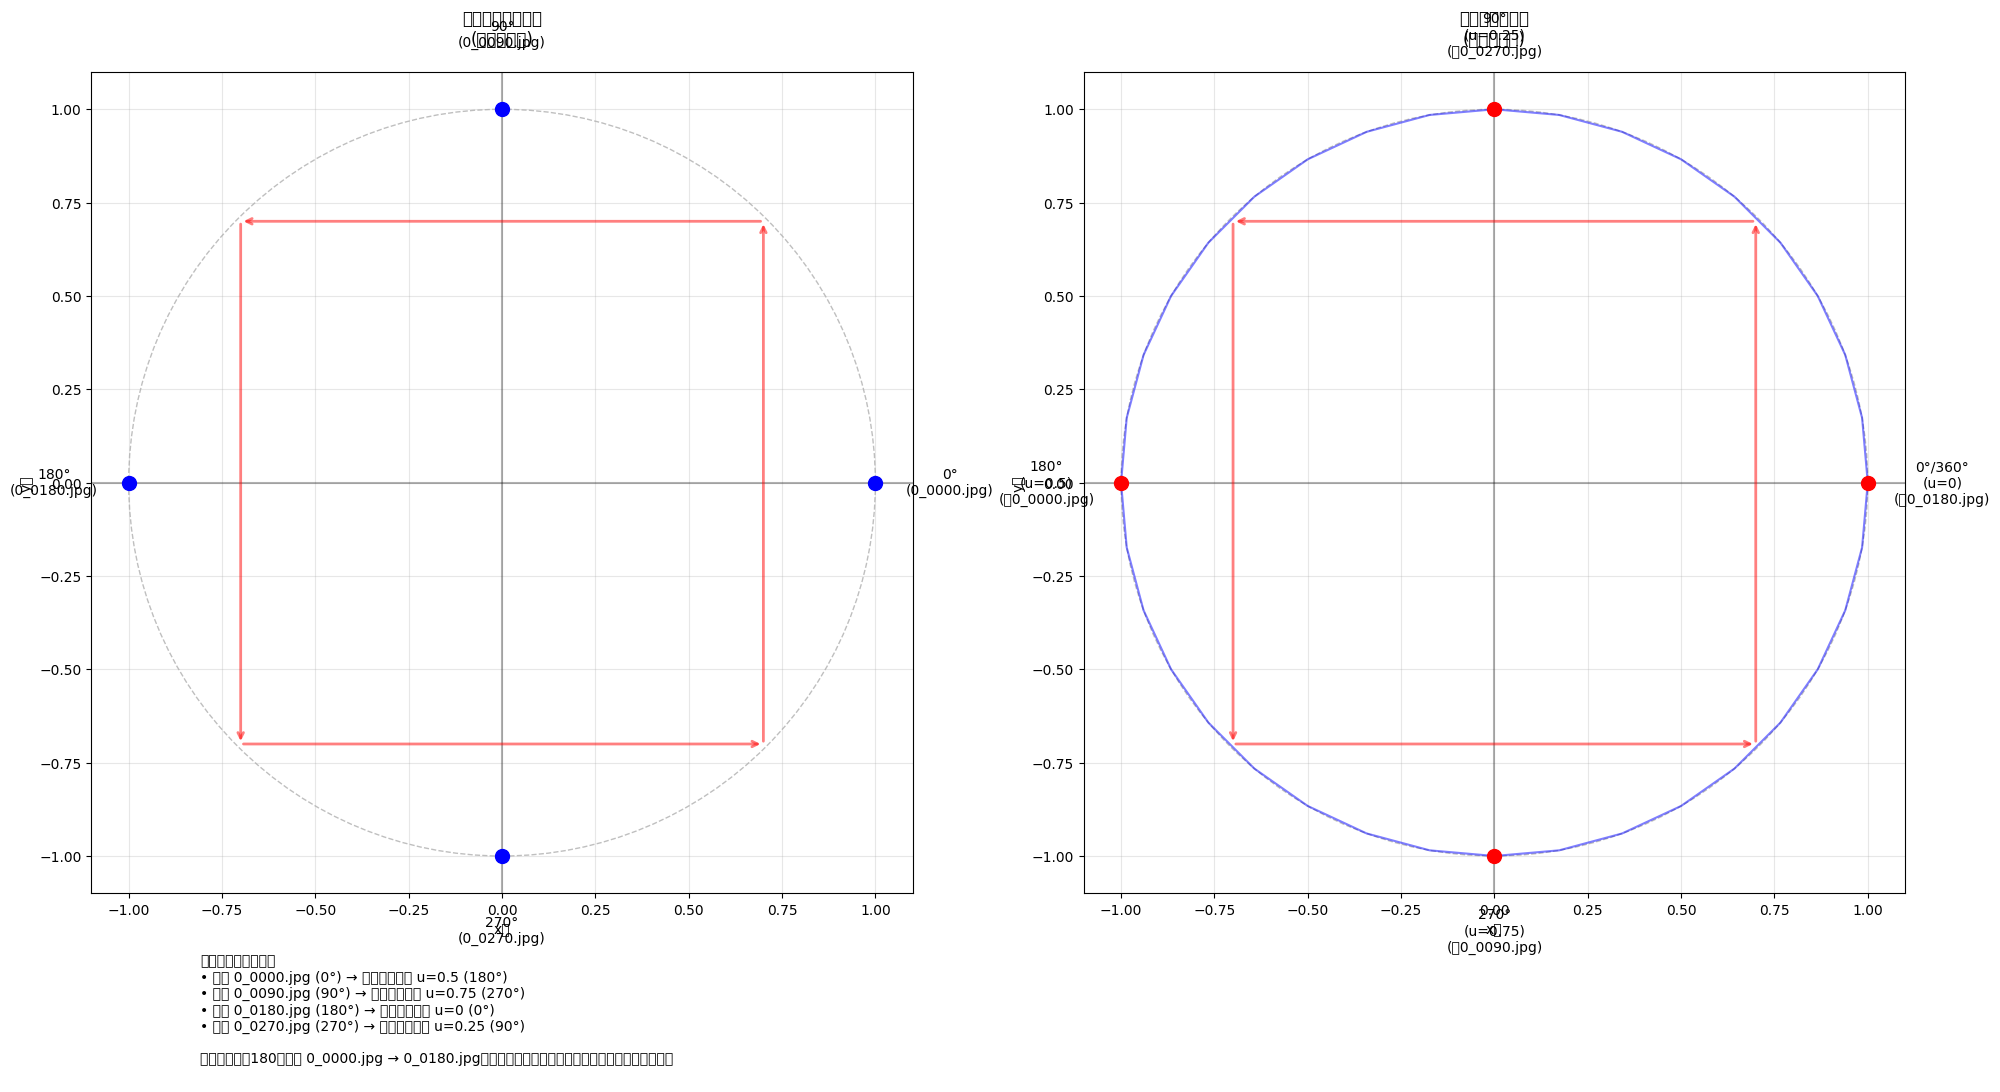

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def to_sphere(u, v):    
    theta = 2 * np.pi * u     
    phi = np.arccos(1 - 2 * v)     
    cx = np.sin(phi) * np.cos(theta)     
    cy = np.sin(phi) * np.sin(theta)     
    cz = np.cos(phi)     
    return np.array([cx, cy, cz])

# 創建兩個子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 左圖：原始命名系統
ax1.set_title('你的原始命名系統\n(逆時針旋轉)', pad=20)
circle1 = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5, transform=ax1.transData)
ax1.add_artist(circle1)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 原始命名的主要方向點
original_points = [(0,1), (-1,0), (0,-1), (1,0)]  # 90°, 180°, 270°, 0°
original_labels = ['90°\n(0_0090.jpg)', '180°\n(0_0180.jpg)', 
                  '270°\n(0_0270.jpg)', '0°\n(0_0000.jpg)']
for point, label in zip(original_points, original_labels):
    ax1.plot(point[0], point[1], 'bo', markersize=10)
    ax1.text(point[0]*1.2, point[1]*1.2, label, ha='center', va='center')

# 右圖：模型的座標系統
ax2.set_title('模型的座標系統\n(逆時針旋轉)', pad=20)
circle2 = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5, transform=ax2.transData)
ax2.add_artist(circle2)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 計算模型座標系統的點
v = 0.5
u_values = np.linspace(0, 1, 37)
points = [to_sphere(u, v) for u in u_values]
x_coords = [p[0] for p in points]
y_coords = [p[1] for p in points]
ax2.plot(x_coords, y_coords, 'b-', alpha=0.5, label='旋轉路徑')

# 模型座標系統的主要方向點
model_points = [(1,0), (0,1), (-1,0), (0,-1)]  # 0°, 90°, 180°, 270°
model_labels = ['0°/360°\n(u=0)\n(原0_0180.jpg)', '90°\n(u=0.25)\n(原0_0270.jpg)', 
                '180°\n(u=0.5)\n(原0_0000.jpg)', '270°\n(u=0.75)\n(原0_0090.jpg)']
for point, label in zip(model_points, model_labels):
    ax2.plot(point[0], point[1], 'ro', markersize=10)
    ax2.text(point[0]*1.2, point[1]*1.2, label, ha='center', va='center')

# 在兩個圖上添加箭頭表示旋轉方向
arrow_positions = [(0.7,0.7), (-0.7,0.7), (-0.7,-0.7), (0.7,-0.7)]
for i in range(len(arrow_positions)-1):
    ax1.annotate('', xy=arrow_positions[i+1], xytext=arrow_positions[i],
                arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))
    ax2.annotate('', xy=arrow_positions[i+1], xytext=arrow_positions[i],
                arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))
ax1.annotate('', xy=arrow_positions[0], xytext=arrow_positions[-1],
            arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))
ax2.annotate('', xy=arrow_positions[0], xytext=arrow_positions[-1],
            arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))

# 設置圖形屬性
for ax in [ax1, ax2]:
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlabel('x軸')
    ax.set_ylabel('y軸')

# 添加說明文字
explanation = """
命名系統對應關係：
• 原始 0_0000.jpg (0°) → 在模型中對應 u=0.5 (180°)
• 原始 0_0090.jpg (90°) → 在模型中對應 u=0.75 (270°)
• 原始 0_0180.jpg (180°) → 在模型中對應 u=0 (0°)
• 原始 0_0270.jpg (270°) → 在模型中對應 u=0.25 (90°)

當你把檔名加180（比如 0_0000.jpg → 0_0180.jpg）時，正好讓檔名中的角度對應到模型的角度系統。
"""
plt.figtext(0.1, -0.1, explanation, fontsize=10, ha='left')

plt.tight_layout()
plt.show()

In [58]:
 K= np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

K[0][2]

64.0

模型0度位置的笛卡爾座標: [1.000000e+00 0.000000e+00 6.123234e-17]


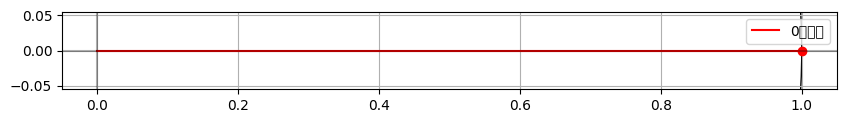

角度: 0°, u=0.0, 座標: [1.000000e+00 0.000000e+00 6.123234e-17]
角度: 90°, u=0.25, 座標: [6.123234e-17 1.000000e+00 6.123234e-17]
角度: 180°, u=0.5, 座標: [-1.0000000e+00  1.2246468e-16  6.1232340e-17]
角度: 270°, u=0.75, 座標: [-1.8369702e-16 -1.0000000e+00  6.1232340e-17]
角度: 0°
u值: 0.0
θ (弧度): 0.0
θ (角度): 0.0°
座標點: [1.000000e+00 0.000000e+00 6.123234e-17]

角度: 90°
u值: 0.25
θ (弧度): 1.5707963267948966
θ (角度): 90.0°
座標點: [6.123234e-17 1.000000e+00 6.123234e-17]

角度: 180°
u值: 0.5
θ (弧度): 3.141592653589793
θ (角度): 180.0°
座標點: [-1.0000000e+00  1.2246468e-16  6.1232340e-17]

角度: 270°
u值: 0.75
θ (弧度): 4.71238898038469
θ (角度): 270.0°
座標點: [-1.8369702e-16 -1.0000000e+00  6.1232340e-17]



In [56]:
# 測試0度位置
u_zero = 0  # 模型的0度
point_at_zero = to_sphere(u_zero, 0.5)  # v=0.5 代表在赤道平面
print(f"模型0度位置的笛卡爾座標: {point_at_zero}")

# 應該會輸出約 [1, 0, 0] 如果0度在正x軸

import numpy as np
import matplotlib.pyplot as plt

def visualize_direction():
    # 創建一個新的圖
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    # 畫一個單位圓
    circle = plt.Circle((0, 0), 1, fill=False)
    ax.add_artist(circle)
    
    # 測試0度位置
    u_zero = 0
    point = to_sphere(u_zero, 0.5)
    
    # 畫出這個點
    ax.plot([0, point[0]], [0, point[1]], 'r-', label='0度方向')
    ax.plot(point[0], point[1], 'ro')
    
    # 添加座標軸
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    plt.show()

visualize_direction()

def test_angles():
    test_angles = [0, 90, 180, 270]
    for angle in test_angles:
        u = angle / 360.0
        point = to_sphere(u, 0.5)
        print(f"角度: {angle}°, u={u}, 座標: {point}")
        
test_angles()

def check_transformation(angle_degrees):
    """檢查特定角度的轉換"""
    u = angle_degrees / 360.0
    theta = 2 * np.pi * u
    point = to_sphere(u, 0.5)
    
    print(f"角度: {angle_degrees}°")
    print(f"u值: {u}")
    print(f"θ (弧度): {theta}")
    print(f"θ (角度): {np.degrees(theta)}°")
    print(f"座標點: {point}\n")

# 測試關鍵角度
for angle in [0, 90, 180, 270]:
    check_transformation(angle)